In [1]:
# http://www.cs.utoronto.ca/~gkoch/files/msc-thesis.pdf
# https://www.cs.cmu.edu/~rsalakhu/papers/oneshot1.pdf

In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
import matplotlib.pyplot as plt

from fastai.vision import *
from fastai.metrics import accuracy_thresh
from fastai.basic_data import *

from fastai.callbacks.hooks import num_features_model, model_sizes
from fastai.layers import BCEWithLogitsFlat
from fastai.basic_train import Learner
from fastai.utils.collect_env import *

from torch.utils.data import DataLoader, Dataset
from torch import nn

from skimage.util import montage
import pandas as pd

from torch import optim
import re

from functional import seq

from os.path import isfile
from utils import *

In [4]:
show_install()



```text
=== Software === 
python        : 3.7.0
fastai        : 1.0.40.dev0
fastprogress  : 0.1.18
torch         : 1.0.0
nvidia driver : 396.54
torch cuda    : 9.0.176 / is available
torch cudnn   : 7401 / is enabled

=== Hardware === 
nvidia gpus   : 1
torch devices : 1
  - gpu0      : 8116MB | GeForce GTX 1080

=== Environment === 
platform      : Linux-4.15.0-43-generic-x86_64-with-debian-buster-sid
distro        : Ubuntu 18.04 Bionic Beaver
conda env     : fastai_updated
python        : /home/dollofcuty/anaconda3/envs/fastai_updated/bin/python
sys.path      : 
/media/dollofcuty/E604249504246B2F/Users/chrun/Documents/Projects/Machine Learning/unstructured data/whale-identification
/home/dollofcuty/anaconda3/envs/fastai_updated/lib/python37.zip
/home/dollofcuty/anaconda3/envs/fastai_updated/lib/python3.7
/home/dollofcuty/anaconda3/envs/fastai_updated/lib/python3.7/lib-dynload
/home/dollofcuty/anaconda3/envs/fastai_updated/lib/python3.7/site-packages
/home/dollofcuty/fastai
/home/do

In [5]:
# import fastai
# from fastprogress import force_console_behavior
# import fastprogress
# fastprogress.fastprogress.NO_BAR = True
# master_bar, progress_bar = force_console_behavior()
# fastai.basic_train.master_bar, fastai.basic_train.progress_bar = master_bar, progress_bar

Posing the problem as a classification task is probably not ideal. We are asking our NN to learn to recognize a whale out of 5004 possible candidates based on what it has learned about the whales. That is a tall order.

Instead, here we will try to pose the problem as a verification task. When presented with two images of whale flukes, we will ask the network - are the images of the same whale or of different whales? In particular, we will try to teach our network to learn features that can be useful in determining the similarity between whale images (hence the name of this approach - feature learning).

This seems like a much easier task, at least in theory. Either way, no need to start with a relatively big CNN like resnet50. Let's see what mileage we can get out of resnet18.

In [6]:
# new architecture calls for a new validation set, this time our validation set will consist of all whales that have exactly two images
df = pd.read_csv('data/train.csv')
im_count = df[df.Id != 'new_whale'].Id.value_counts()
im_count.name = 'sighting_count'
df = df.join(im_count, on='Id')
val_fns = set(df[df.sighting_count == 2].Image)

In [7]:
len(df), len(val_fns)

(25361, 2570)

In [9]:
fn2label = {row[1].Image: row[1].Id for row in df.iterrows()}
path2fn = lambda path: re.search('\w*\.jpg$', path).group(0)

name = f'res34-siamese-differenthead'

In [10]:
SZ = 224
BS = 64
NUM_WORKERS = 8
SEED=0

In [11]:
# data_block api creates categories based on classes it sees in the train set and
# our val set contains whales whose ids do not appear in the train set
classes = df.Id.unique()

In [11]:
data = (
    ImageItemList
        .from_df(df[df.Id != 'new_whale'], f'data/train-{SZ}', cols=['Image'])
        .split_by_valid_func(lambda path: path2fn(path) in val_fns)
        .label_from_func(lambda path: fn2label[path2fn(path)], classes=classes)
        .add_test(ImageItemList.from_folder(f'data/test-{SZ}'))
        .transform(get_transforms(max_lighting=0.3, max_zoom=1., do_flip=False),
                   size=SZ, resize_method=ResizeMethod.SQUISH)
)

I am still using the ImageItemList even though I will create my own datasets. Why? Because I want to reuse the functionality that is already there (creating datasets from files, augmentations, resizing, etc).

I realize the code is neither clean nor elegant but for the time being I am happy with this approach.

In [12]:
#bb = pd.read_csv('data/bounding_boxes.csv')
#bb.head()

In [13]:
#open_image('data/train/72c3ce75c.jpg').shape

In [14]:
#len(bb)

In [15]:
#train_paths = os.listdir('data/train')
#test_paths = os.listdir('data/test')

In [16]:
#for i, img in bb.iterrows():
#    if i % 10000 == 0: print(i)
#    if img.Image in train_paths:
#        size = open_image(f'data/train/{img.Image}').shape
#        ratio1 = size[1]/224
#        ratio2 = size[2]/224
#        bb.at[i, 'x0'] = round(img.x0 / ratio2, 4)
#        bb.at[i, 'y0'] = round(img.y0 / ratio1, 4)
#        bb.at[i, 'x1'] = round(img.x1 / ratio2, 4)
#        bb.at[i, 'y1'] = round(img.y1 / ratio1, 4)
#    else:
#        size = open_image(f'data/test/{img.Image}').shape
#        ratio1 = size[1]/224
#        ratio2 = size[2]/224
#        bb.at[i, 'x0'] = round(img.x0 / ratio2, 4)
#        bb.at[i, 'y0'] = round(img.y0 / ratio1, 4)
#        bb.at[i, 'x1'] = round(img.x1 / ratio2, 4)
#        bb.at[i, 'y1'] = round(img.y1 / ratio1, 4)

In [17]:
#bb.to_csv('data/bounding_boxes224.csv', index=False)

In [18]:
bb = pd.read_csv('data/bounding_boxes.csv')
bb.set_index('Image', inplace=True)
bb.head()

x0  y0    x1   y1
Image                           
72c3ce75c.jpg   0   0  1045  389
a7ad640ee.jpg  35  71   523  291
df2b6c364.jpg  12  15  1033  308
26013fcb5.jpg   3   1  1024  292
09eff7b37.jpg  11   8   926  334

In [19]:
#todo: try multiple images at once (lap solution maybe)

In [20]:
def is_even(num): return num % 2 == 0

class TwoImDataset(Dataset):
    def __init__(self, ds):
        self.ds = ds
        self.x = ds.x
        self.y = ds.y
        self.whale_ids = ds.y.items
    def __len__(self):
        return 2 * len(self.ds)
    def __getitem__(self, idx):
        if is_even(idx):
            return self.sample_same(idx // 2)
        else: return self.sample_different((idx-1) // 2)
    def sample_same(self, idx):
        whale_id = self.whale_ids[idx]        
        candidates = list(np.where(self.whale_ids == whale_id)[0])
        candidates.remove(idx) # dropping our current whale - we don't want to compare against an identical image!
        
        if len(candidates) == 0: # oops, there is only a single whale with this id in the dataset
            return self.sample_different(idx)
        
        np.random.shuffle(candidates)
        return self.construct_example(self.ds[idx][0], self.ds[candidates[0]][0], 1)
    
    def sample_different(self, idx):
        whale_id = self.whale_ids[idx]
        candidates = list(np.where(self.whale_ids != whale_id)[0])
        np.random.shuffle(candidates)
        return self.construct_example(self.ds[idx][0], self.ds[candidates[0]][0], 0)
    
    def construct_example(self, im_A, im_B, class_idx):
        return [im_A, im_B], class_idx

In [21]:
train_dl = DataLoader(
    TwoImDataset(data.train),
    batch_size=BS,
    shuffle=True,
    num_workers=NUM_WORKERS
)
valid_dl = DataLoader(
    TwoImDataset(data.valid),
    batch_size=BS,
    shuffle=False,
    num_workers=NUM_WORKERS
)

data_bunch = ImageDataBunch(train_dl, valid_dl)

In [22]:
len(data_bunch.valid_ds)

5140

In [23]:
#data_bunch.train_ds.ds.x.convert_mode = 'L'
#data_bunch.valid_ds.ds.x.convert_mode = 'L'

In [24]:
import types

In [25]:
def one_batch(self, ds_type:DatasetType=DatasetType.Train, detach:bool=True, denorm:bool=True, cpu:bool=True)->Collection[Tensor]:
        "Get one batch from the data loader of `ds_type`. Optionally `detach` and `denorm`."
        dl = self.dl(ds_type)
        w = self.num_workers
        self.num_workers = 0
        try:     x,y = next(iter(dl))
        finally: self.num_workers = w
        if detach: x,y = to_detach(x,cpu=cpu),to_detach(y,cpu=cpu)
        norm = getattr(self,'norm',False)
        if denorm and norm:
            x = self.denorm(x)
            if norm.keywords.get('do_y',False): y = self.denorm(y, do_x=True)
        return x[0],y

In [26]:
data_bunch.one_batch = types.MethodType(one_batch,data_bunch)

In [27]:
data_bunch.one_batch()[0].shape

torch.Size([64, 3, 224, 224])

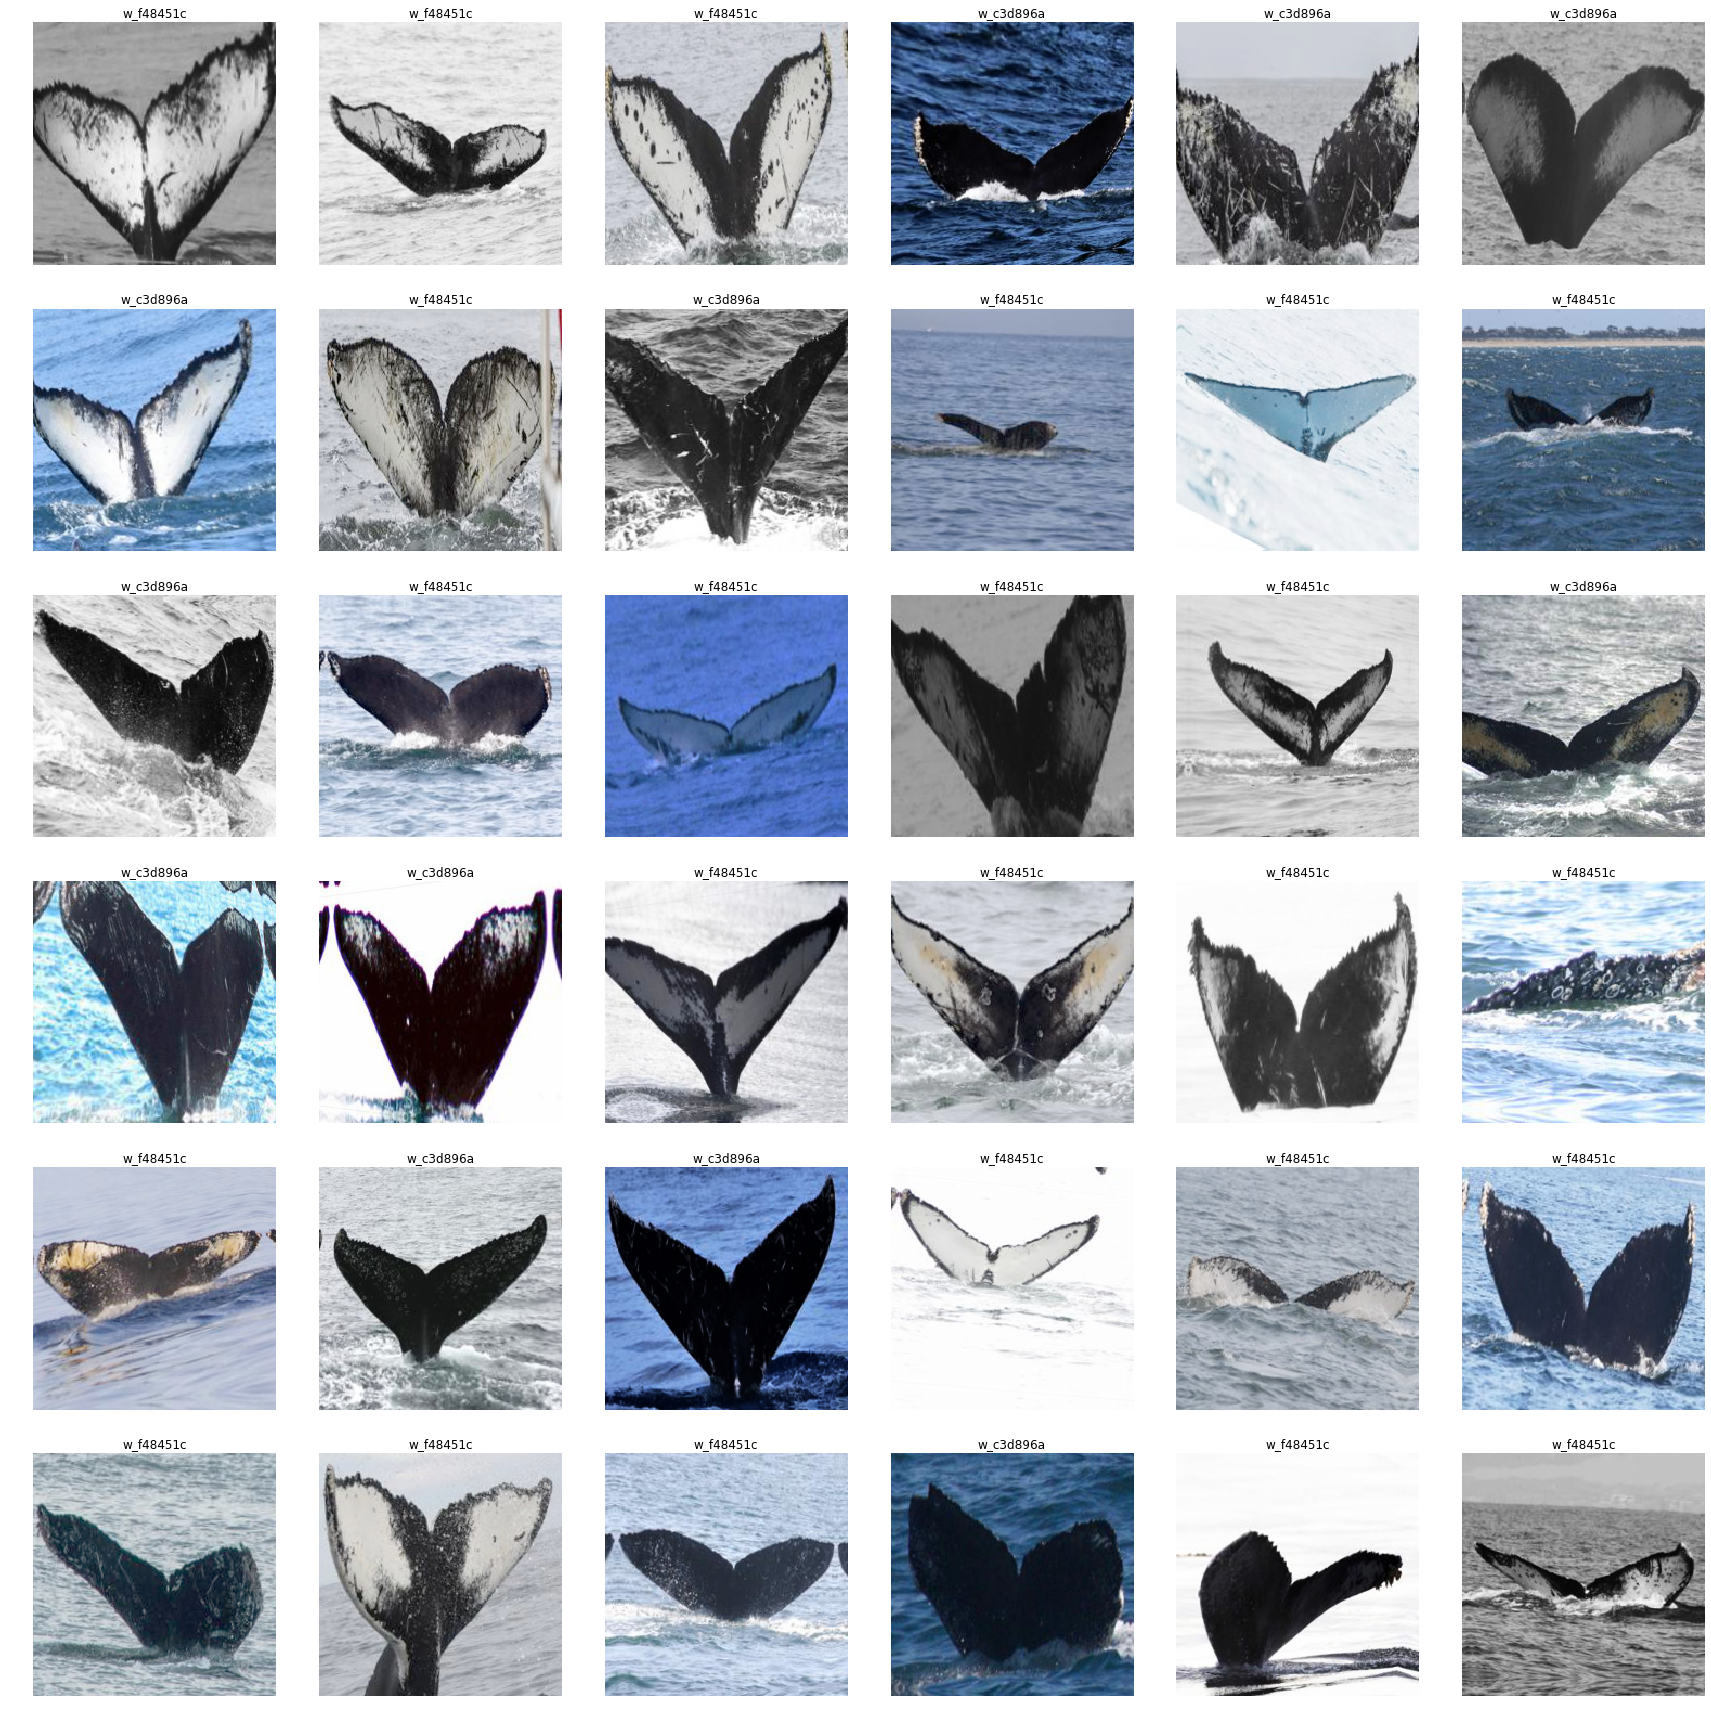

In [28]:
data_bunch.show_batch(6, DatasetType.Train)

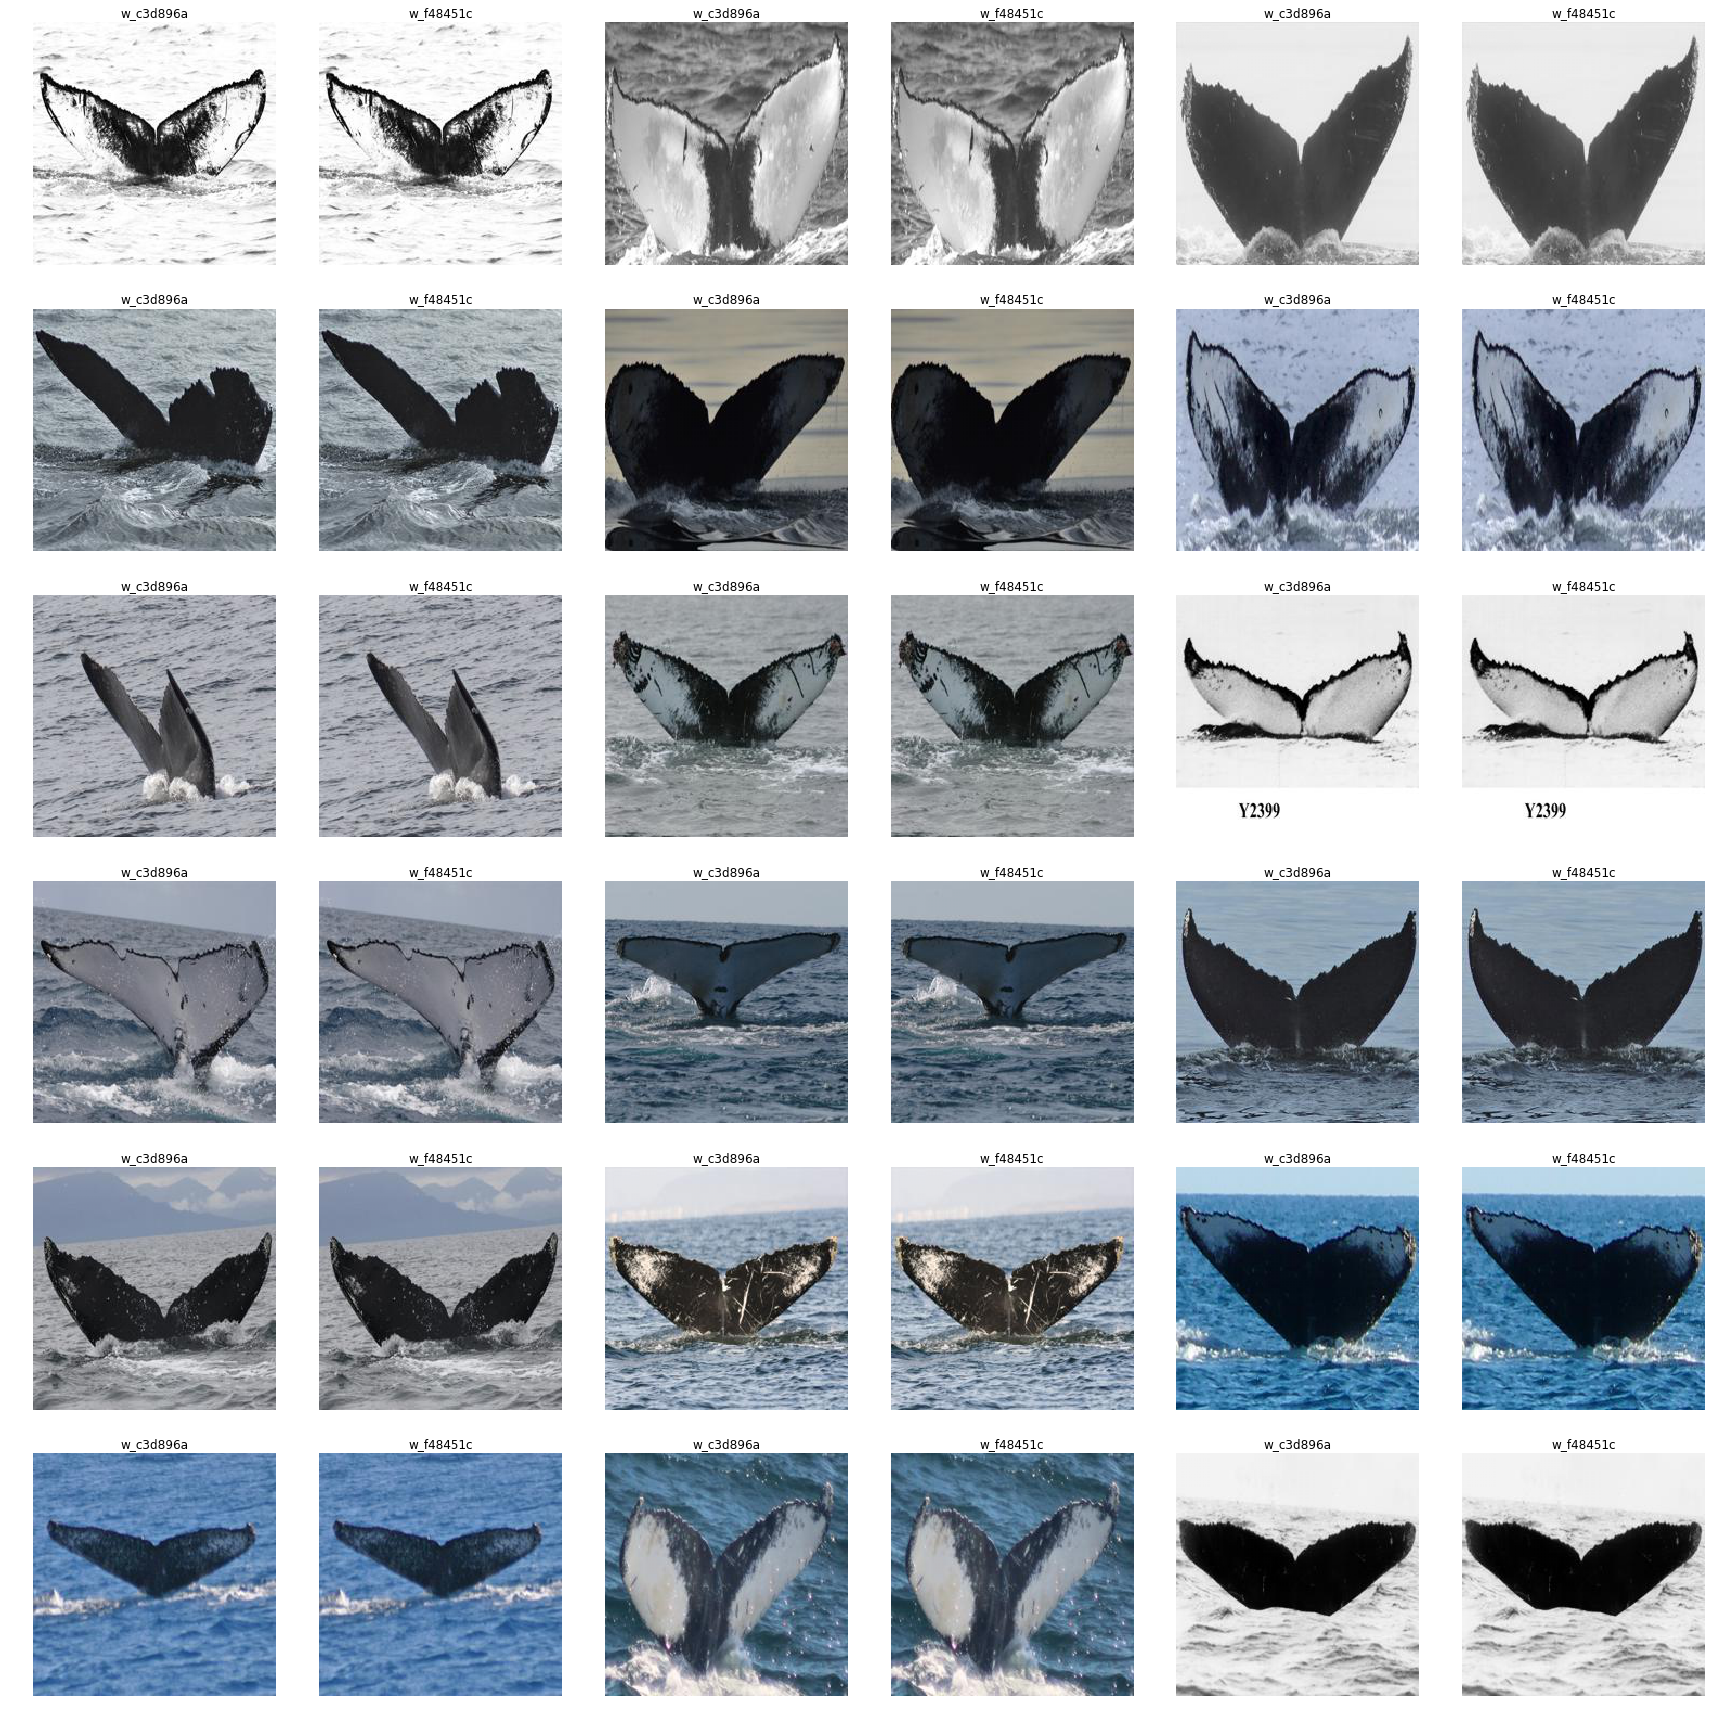

In [29]:
data_bunch.show_batch(6, DatasetType.Valid)

In [30]:
#import PIL
#from PIL import ImageStat

In [31]:
#paths = np.append(np.append(data.train.x.items, data.valid.x.items), data.test.x.items)

In [32]:
#means = torch.zeros(1)
#stds = torch.zeros(1) 
#
#count =  len(paths)
#count

In [33]:
#for i, fname in enumerate(paths):    
#    img = Image(pil2tensor(PIL.Image.open(fname).convert('L'),np.float32).div_(255)).data
#    #print(img.shape)
#    means += torch.Tensor([torch.mean(img[0])])
#    stds += torch.Tensor([torch.std(img[0])])
#    if i % 10000 == 0: print(i)
#
#mean = means/count
#std = stds/count
#mean, std

In [34]:
#for i, fname in enumerate(paths):    
#    img = Image(pil2tensor(PIL.Image.open(fname).convert('L'),np.float32).div_(255)).data
#    print(img.shape)
#    means += torch.Tensor([torch.mean(img[0]),torch.mean(img[1]),torch.mean(img[2])])
#    stds += torch.Tensor([torch.std(img[0]),torch.std(img[1]),torch.std(img[2])])
#    if i % 10000 == 0: print(i)
#
#mean = means/count
#std = stds/count
#mean, std

In [35]:
#stats_single = ([0.5484],[0.2163])

In [36]:
stats = ([0.5175, 0.5562, 0.6008], [0.2160, 0.2171, 0.2212])

In [37]:
def normalize_batch(batch):
    stat_tensors = [torch.tensor(l).cuda() for l in stats]
    return [normalize(batch[0][0], *stat_tensors), normalize(batch[0][1], *stat_tensors)], batch[1]

In [38]:
data_bunch.add_tfm(normalize_batch)

In [39]:
class TrackerCallback(LearnerCallback):
    "A `LearnerCallback` that keeps track of the best value in `monitor`."
    def __init__(self, learn:Learner, monitor:str='val_loss', mode:str='auto'):
        super().__init__(learn)
        self.monitor,self.mode = monitor,mode
        if self.mode not in ['auto', 'min', 'max']:
            warn(f'{self.__class__} mode {self.mode} is invalid, falling back to "auto" mode.')
            self.mode = 'auto'
        mode_dict = {'min': np.less, 'max':np.greater}
        mode_dict['auto'] = np.less if 'loss' in self.monitor else np.greater
        self.operator = mode_dict[self.mode]

    def on_train_begin(self, **kwargs:Any)->None:
        "Initializes the best value."
        self.best = float('inf') if self.operator == np.less else -float('inf')

    def get_monitor_value(self):
        "Pick the monitored value."
        if self.monitor=='trn_loss' and len(self.learn.recorder.losses) == 0: return None
        elif len(self.learn.recorder.val_losses) == 0: return None
        values = {'trn_loss':self.learn.recorder.losses[-1:][0].cpu().numpy(),
                  'val_loss':self.learn.recorder.val_losses[-1:][0]}
        for i, name in enumerate(self.learn.recorder.names[3:]):
            values[name]=self.learn.recorder.metrics[-1:][0][i]
        if values.get(self.monitor) is None:
            warn(f'{self.__class__} conditioned on metric `{self.monitor}` which is not available. Available metrics are: {", ".join(map(str, self.learn.recorder.names[1:]))}')
        return values.get(self.monitor)

In [40]:
class SaveModel(TrackerCallback):
    "A `TrackerCallback` that saves the model when monitored quantity is best."
    def __init__(self, learn:Learner, monitor:str='val_loss', mode:str='auto', every:str='improvement', name:str='bestmodel'):
        super().__init__(learn, monitor=monitor, mode=mode)
        self.every,self.name = every,name
        if self.every not in ['improvement', 'epoch']:
            warn(f'SaveModel every {self.every} is invalid, falling back to "improvement".')
            self.every = 'improvement'

    def on_epoch_end(self, epoch, **kwargs:Any)->None:
        "Compare the value monitored to its best score and maybe save the model."
        if self.every=="epoch": self.learn.save(f'{self.name}_{epoch}')
        else: #every="improvement"
            current = self.get_monitor_value()
            if current is not None and self.operator(current, self.best):
                self.best = current
                self.learn.save(f'{self.name}')

    def on_train_end(self, **kwargs):
        "Load the best model."
        if self.every=="improvement" and (self.learn.path/f'{self.learn.model_dir}/{self.name}.pth').is_file():
            self.learn.load(f'{self.name}')

In [41]:
from functional import seq

class SiameseNetwork(nn.Module):
    def __init__(self, arch=models.resnet34):
        super().__init__()
        self.cnn = create_body(arch)
        
        #self.cnn[0] = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        actn = nn.ReLU(inplace=True)
        
        mid = 32
        self.conv1 =  nn.Sequential(*[nn.Conv2d(1,mid, kernel_size = (  1, 4), padding = 0, stride=1), actn])
        self.conv2 =  nn.Sequential(*[nn.Conv2d(1,  1, kernel_size = (mid, 1), padding = 0, stride=1), Flatten()])
        
        #self.conv1 = nn.Sequential(*[conv2d(4, mid, stride=(1,4)), actn])
        #self.conv2 = nn.Sequential(*[conv2d(mid, 1, stride=(1,mid)), Flatten()])
        
        self.fc = nn.Linear(512, 1, bias=True)

    def forward(self, im_A, im_B):
        x1, x2 = seq(im_A, im_B).map(self.cnn).map(self.process_features)#.map(self.pooling)
        #print(x1.shape, x2.shape)
        feat = self.calculate_features(x1, x2)
        #print(feat.shape)
        feat = feat.view(-1, 1, num_features_model(self.cnn), 4)
        con1 = self.conv1(feat)
        #print(con1.shape)
        con1 = con1.view(-1, 1, 32, num_features_model(self.cnn))
        con2 = self.conv2(con1)
        #print(con2.shape)
        con2 = con2.view(-1, num_features_model(self.cnn))
        out = self.fc(con2)
        #print(out)
        return out

    def calculate_features(self, x1, x2):
        mu = x1 * x2
        ad = x1 + x2
        mi = torch.abs(x1-x2)
        sq = mi**2
        x = torch.cat([mu, ad, mi, sq], dim=1)
        return x

    def process_features(self, x): 
        y = x.reshape(*x.shape[:2], -1)
        return x.reshape(*x.shape[:2], -1).max(-1)[0]
    
#    def process_features(self, x):
#        return x.view(x.shape[0], 4, 512, 1)

#    def pooling(self, x):
#        return F.max_pool2d(x, kernel_size=x.size()[2:])

In [42]:
learn = Learner(data_bunch, SiameseNetwork(), loss_func=BCEWithLogitsFlat(), callback_fns=[ShowGraph],
                metrics=[lambda preds, targs: accuracy_thresh(preds.squeeze(), targs, sigmoid=False)])

In [43]:
#learn.data.train_ds.ds.x.convert_mode = 'L'
#learn.data.valid_ds.ds.x.convert_mode = 'L'

In [44]:
learn.split([learn.model.cnn[:6], learn.model.cnn[6:], learn.model.conv1])

In [45]:
learn.layer_groups

[Sequential(
   (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
   (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (2): ReLU(inplace)
   (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
   (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
   (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (6): ReLU(inplace)
   (7): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
   (8): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (9): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
   (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (11): ReLU(inplace)
   (12): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
   (13): BatchNorm2d(64, eps=1e-05, momentum=0.1, affi

In [46]:
learn.freeze_to(-1)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


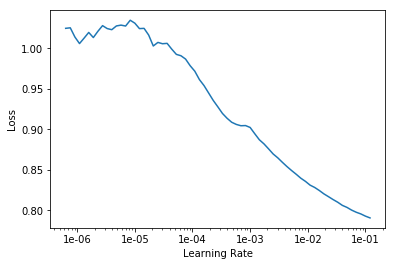

In [47]:
learn.lr_find()
learn.recorder.plot()

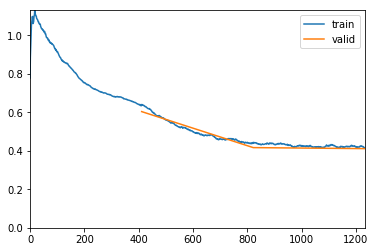

In [47]:
learn.fit_one_cycle(3, 2e-4)

In [48]:
learn.save(f'{name}-{SZ}-stage-1')

In [49]:
learn.unfreeze()

In [50]:
learn.callback_fns.append(partial(SaveModel, every='improvement', name=f'{name}-{SZ}-stage-2'))

In [51]:
max_lr = 1e-4
lrs = slice(max_lr/9,max_lr)
learn.lr_range(lrs)

array([1.111111e-05, 3.333333e-05, 1.000000e-04])

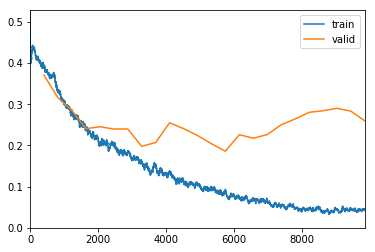

In [52]:
learn.fit_one_cycle(24, lrs) #1e-4, 24e, slice(max_lr/9,max_lr), div_factor=25

The model is not doing that well - out of presented pairs it gets roughly 10% of examples wrong. I also did a cursory error analysis (not shown here for the sake of brevity) and the model is not doing that great at all.

How can this be? Maybe the nearly absolute positional invariance through the use of global max pooling is not working that well. Maybe there is a bug somewhere? Maybe the model has not been trained for long enough or lacks capacity?

If I do continue to work on this I will definitely take a closer look at each of the angles I list above. For the time being, let's try to predict on the validation set and finish off with making a submission.

The predicting part is where the code gets really messy. That is good enough for now though.

## Size 448px

In [46]:
SZ_BIG =2*SZ
BS = 16
NUM_WORKERS = 8

In [47]:
data = (
    ImageItemList
        .from_df(df[df.Id != 'new_whale'], f'data/train-{SZ_BIG}', cols=['Image'])
        .split_by_valid_func(lambda path: path2fn(path) in val_fns)
        .label_from_func(lambda path: fn2label[path2fn(path)], classes=classes)
        .add_test(ImageItemList.from_folder(f'data/test-{SZ_BIG}'))
        .transform(get_transforms(max_lighting=0.3, max_zoom=1., do_flip=False),
                   size=SZ_BIG, resize_method=ResizeMethod.SQUISH)
)

In [48]:
#data.train.x.convert_mode = 'L'
#data.valid.x.convert_mode = 'L'
#data.test.x.convert_mode = 'L'

In [49]:
train_dl = DataLoader(
    TwoImDataset(data.train),
    batch_size=BS,
    shuffle=True,
    num_workers=NUM_WORKERS
)
valid_dl = DataLoader(
    TwoImDataset(data.valid),
    batch_size=BS,
    shuffle=False,
    num_workers=NUM_WORKERS
)

In [50]:
data_bunch = ImageDataBunch(train_dl, valid_dl)

data_bunch.add_tfm(normalize_batch)

In [51]:
learn = Learner(data_bunch, SiameseNetwork(), loss_func=BCEWithLogitsFlat(), callback_fns=[ShowGraph],
                metrics=[lambda preds, targs: accuracy_thresh(preds.squeeze(), targs, sigmoid=False)])

In [52]:
#learn.data.train_ds.ds.x.convert_mode = 'L'
#learn.data.valid_ds.ds.x.convert_mode = 'L'

In [53]:
learn.split([learn.model.cnn[:6], learn.model.cnn[6:], learn.model.conv1])

In [54]:
learn.layer_groups

[Sequential(
   (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
   (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (2): ReLU(inplace)
   (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
   (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
   (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (6): ReLU(inplace)
   (7): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
   (8): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (9): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
   (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (11): ReLU(inplace)
   (12): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
   (13): BatchNorm2d(64, eps=1e-05, momentum=0.1, affi

In [62]:
learn.load(f'{name}-224-stage-2');

In [63]:
learn.freeze_to(-1)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


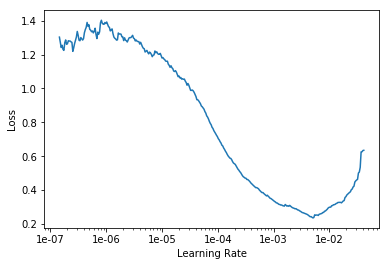

In [64]:
learn.lr_find(num_it=500)
learn.recorder.plot()

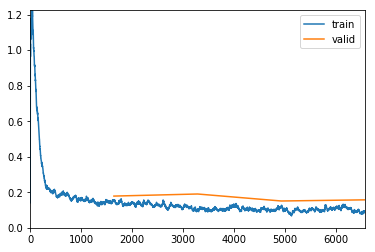

In [65]:
learn.fit_one_cycle(4, 2e-4)

In [66]:
learn.save(f'{name}-{SZ_BIG}-stage-1')

In [67]:
learn.unfreeze()

In [68]:
max_lr = 2e-4
lrs = slice(max_lr/9,max_lr)
learn.lr_range(lrs)

array([2.222222e-05, 6.666667e-05, 2.000000e-04])

In [69]:
learn.callback_fns.append(partial(SaveModel, every='epoch', name=f'{name}-{SZ_BIG}-stage-2'))

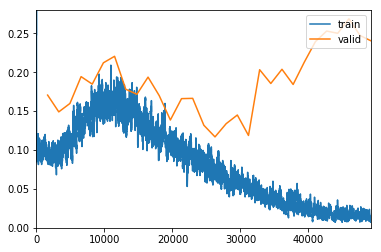

In [70]:
learn.fit_one_cycle(30, lrs, div_factor=50) #1e-4, slice(max_lr/9,max_lr), div_factor=50

In [41]:
learn.callback_fns.pop()

functools.partial(<class '__main__.SaveModel'>, every='improvement', name='res34-siamese-differenthead-448-stage-2')

## validate 

In [109]:
#name='res34-siamese-differenthead'

In [55]:
learn.load(f'{name}-{SZ_BIG}-stage-2_19');

In [56]:
learn.model.eval();

In [57]:
new_whale_fns = set(df[df.Id == 'new_whale'].sample(frac=1).Image.iloc[:1000])
len(new_whale_fns)

1000

In [58]:
SZ_BIG = 448

In [59]:
data = (
    ImageItemList
        .from_df(df, f'data/train-{SZ_BIG}', cols=['Image'])
        .split_by_valid_func(lambda path: path2fn(path) in val_fns.union(new_whale_fns)) #.union(new_whale_fns)
        .label_from_func(lambda path: fn2label[path2fn(path)], classes=classes)
        .add_test(ImageItemList.from_folder(f'data/test-{SZ_BIG}'))
        .transform(get_transforms(max_lighting=0.3, max_zoom=1., do_flip=False), 
                   size=SZ_BIG, resize_method=ResizeMethod.SQUISH)
        .databunch(bs=BS, num_workers=NUM_WORKERS, path='data')
        .normalize(stats)
)

In [60]:
#x1, x2 = seq(im_A, im_B).map(self.cnn).map(self.process_features)#.map(self.pooling)
#feat = self.calculate_features(x1, x2)
#feat = feat.view(-1, 1, num_features_model(self.cnn), 4)
#con1 = self.conv1(feat)
#con1 = con1.view(-1, 1, 32, num_features_model(self.cnn))
#con2 = self.conv2(con1)
#con2 = con2.view(-1, num_features_model(self.cnn))
#out = self.fc(con2)

In [61]:
%%time
targs = []
feats = []
for ims, ts in data.valid_dl:
    #print(ims.shape)
    feats.append(learn.model.process_features(learn.model.cnn(ims)).detach().cpu())
    targs.append(ts)

CPU times: user 12.4 s, sys: 6.42 s, total: 18.8 s
Wall time: 19.7 s


In [62]:
feats = torch.cat(feats)

In [63]:
feats.shape

torch.Size([3570, 512])

In [64]:
%%time
sims = []
for feat in feats:
    x1 = feats
    x2 = feat.unsqueeze(0).repeat(3570 ,1)
    feat = learn.model.calculate_features(x1 , x2)
    feat = feat.view(-1, 1, num_features_model(learn.model.cnn), 4)
    con1 = learn.model.conv1(feat.cuda())
    con1 = con1.view(-1, 1, 32, num_features_model(learn.model.cnn))
    con2 = learn.model.conv2(con1)
    con2 = con2.view(-1, num_features_model(learn.model.cnn))
    predicted_similarity =  learn.model.fc(con2).sigmoid_()
    sims.append(predicted_similarity.squeeze().detach().cpu())

CPU times: user 2min 36s, sys: 12 s, total: 2min 48s
Wall time: 2min 48s


In [65]:
len(sims), sims[0].shape

(3570, torch.Size([3570]))

In [66]:
sims[0].mean()

tensor(0.0361)

In [67]:
new_whale_idx = np.where(classes == 'new_whale')[0][0]

In [68]:
%%time
top_5s = []
for i, sim in enumerate(sims):
    idxs = sim.argsort(descending=True)
    probs = sim[idxs]
    top_5 = []
    for j, p in zip(idxs, probs):
        if len(top_5) == 5: break
        if j == new_whale_idx or j == i: continue
        predicted_class = data.valid_ds.y.items[j]
        if predicted_class not in top_5: top_5.append(predicted_class)
    top_5s.append(top_5)

CPU times: user 1.35 s, sys: 1.07 ms, total: 1.35 s
Wall time: 1.35 s


In [69]:
mapk(data.valid_ds.y.items.reshape(-1,1), np.stack(top_5s), 5)

0.6431232492997199

In [73]:
%%time

thresh_dict = {}

for thresh in np.linspace(0.990, 1, 21):
    top_5s = []
    for i, sim in enumerate(sims):
        idxs = sim.argsort(descending=True)
        probs = sim[idxs]
        top_5 = []
        for j, p in zip(idxs, probs):
            if new_whale_idx not in top_5 and p < thresh and len(top_5) < 5: top_5.append(new_whale_idx)
            if len(top_5) == 5: break
            if j == new_whale_idx or j == i: continue
            predicted_class = data.valid_ds.y.items[j]
            if predicted_class not in top_5: top_5.append(predicted_class)
        top_5s.append(top_5)
    thresh_dict[thresh] = np.round(mapk(data.valid_ds.y.items.reshape(-1,1), np.stack(top_5s), 5),decimals=6)
    print(thresh, np.round(mapk(data.valid_ds.y.items.reshape(-1,1), np.stack(top_5s), 5),decimals=6))

0.99 0.697544
0.9904999999999999 0.698819
0.991 0.69965
0.9915 0.701078
0.992 0.702591
0.9924999999999999 0.702143
0.993 0.702633
0.9935 0.703749
0.994 0.705266
0.9944999999999999 0.704519
0.995 0.703992
0.9955 0.700425
0.996 0.696004
0.9964999999999999 0.692502
0.997 0.688147
0.9975 0.680047
0.998 0.670803
0.9984999999999999 0.654416
0.999 0.632941
0.9995 0.599188
1.0 0.541811
CPU times: user 32.2 s, sys: 15.6 ms, total: 32.2 s
Wall time: 32.2 s


In [74]:
thresh = max(thresh_dict, key=thresh_dict.get)
thresh

0.994

In [75]:
#best thresh: 0.999

In [76]:
%%time

top_5s = []
for i, sim in enumerate(sims):
    idxs = sim.argsort(descending=True)
    probs = sim[idxs]
    top_5 = []
    for j, p in zip(idxs, probs):
        if new_whale_idx not in top_5 and p < thresh and len(top_5) < 5: top_5.append(new_whale_idx)
        if len(top_5) == 5: break
        if j == new_whale_idx or j == i: continue
        predicted_class = data.valid_ds.y.items[j]
        if predicted_class not in top_5: top_5.append(predicted_class)
    top_5s.append(top_5)

CPU times: user 1.33 s, sys: 68 µs, total: 1.33 s
Wall time: 1.33 s


In [77]:
# without predicting new_whale
mapk(data.valid_ds.y.items.reshape(-1,1), np.stack(top_5s), 5)

0.705266106442577

There are many reasons why the best threshold here might not carry over to what would make sense on the test set. It is some indication though of how our model is doing and a useful data point.

## Predict

In [78]:
len(data.test_ds)

7960

In [79]:
data = (
    ImageItemList
        .from_df(df, f'data/train-{SZ_BIG}', cols=['Image'])
        .no_split()
        .label_from_func(lambda path: fn2label[path2fn(path)], classes=classes)
        .add_test(ImageItemList.from_folder(f'data/test-{SZ_BIG}'))
        .transform(get_transforms(max_lighting=0.3, max_zoom=1., do_flip=False), 
                   size=SZ_BIG, resize_method=ResizeMethod.SQUISH)
        .databunch(bs=BS, num_workers=NUM_WORKERS, path='data')
        .normalize(stats)
)

In [80]:
%%time
test_feats = []
learn.model.eval()
for ims, _ in data.test_dl:
    test_feats.append(learn.model.process_features(learn.model.cnn(ims)).detach().cpu())

CPU times: user 27.6 s, sys: 14.1 s, total: 41.7 s
Wall time: 42.4 s


In [81]:
%%time
train_feats = []
train_class_idxs = []
learn.model.eval()
for ims, t in data.train_dl:
    train_feats.append(learn.model.process_features(learn.model.cnn(ims)).detach().cpu())
    
    train_class_idxs.append(t)

CPU times: user 1min 37s, sys: 46 s, total: 2min 23s
Wall time: 2min 25s


In [82]:
train_class_idxs = torch.cat(train_class_idxs)
train_feats = torch.cat(train_feats)

In [83]:
test_feats = torch.cat(test_feats)

In [109]:
train_feats.shape, test_feats.shape

(torch.Size([25360, 512]), torch.Size([7960, 512]))

In [113]:
%%time
sims = []
for feat in test_feats:
    x1 = train_feats
    x2 = feat.unsqueeze(0).repeat(25360, 1)
    feat = learn.model.calculate_features(x1 , x2)
    feat = feat.view(-1, 1, num_features_model(learn.model.cnn), 4)
    con1 = learn.model.conv1(feat.cuda())
    con1 = con1.view(-1, 1, 32, num_features_model(learn.model.cnn))
    con2 = learn.model.conv2(con1)
    con2 = con2.view(-1, num_features_model(learn.model.cnn))
    predicted_similarity =  learn.model.fc(con2).sigmoid_()
    sims.append(predicted_similarity.squeeze().detach().cpu())

CPU times: user 27min 43s, sys: 18min 8s, total: 45min 51s
Wall time: 45min 55s


In [85]:
#todo: verify thresh

In [114]:
thresh

0.994

In [173]:
thresh = 0.9975

In [174]:
%%time

top_5s = []
for sim in sims:
    idxs = sim.argsort(descending = True)
    probs = sim[idxs]
    top_5 = []
    for  i , p in zip(idxs , probs):
        if new_whale_idx not in top_5 and p < thresh and len(top_5) < 5:
            top_5.append(new_whale_idx)
        if len(top_5) == 5: break
        #if i == new_whale_idx: continue
        predicted_class = train_class_idxs[i]
        #print(predicted_class)
        if predicted_class == new_whale_idx: continue
        if predicted_class not in top_5:
            top_5.append(predicted_class)
    top_5s.append(top_5)

CPU times: user 23 s, sys: 796 ms, total: 23.8 s
Wall time: 23.8 s


In [175]:
top_5_classes = []
for top_5 in top_5s:
    top_5_classes.append(' '.join([classes[t] for t in top_5]))

In [176]:
top_5_classes[:5]

['w_dec7ffd new_whale w_ae53e45 w_42b0064 w_eafeccd',
 'w_4132bb8 new_whale w_ee57fc5 w_6cec90c w_e3956f5',
 'new_whale w_1ebcda9 w_4e63f7a w_d6553ba w_1ccea93',
 'w_59052ad w_c99807e w_2ec0a71 w_d6aa3f3 w_91b678a',
 'w_9e18daa new_whale w_b26e855 w_7a8ce16 w_cb0aaf0']

In [177]:
sub = pd.DataFrame({'Image': [path.name for path in data.test_ds.x.items]})
sub['Id'] = top_5_classes
sub.to_csv(f'subs/{name}-{SZ_BIG}.csv.gz', index=False, compression='gzip')

In [178]:
pd.read_csv(f'subs/{name}-{SZ_BIG}.csv.gz').head()

Image                                                 Id
0  00028a005.jpg  w_dec7ffd new_whale w_ae53e45 w_42b0064 w_eafeccd
1  000dcf7d8.jpg  w_4132bb8 new_whale w_ee57fc5 w_6cec90c w_e3956f5
2  000e7c7df.jpg  new_whale w_1ebcda9 w_4e63f7a w_d6553ba w_1ccea93
3  0019c34f4.jpg  w_59052ad w_c99807e w_2ec0a71 w_d6aa3f3 w_91b678a
4  001a4d292.jpg  w_9e18daa new_whale w_b26e855 w_7a8ce16 w_cb0aaf0

In [188]:
pd.read_csv(f'subs/{name}-{SZ_BIG}.csv.gz').Id.str.split().apply(
    lambda x: x[0] == 'new_whale').mean()

0.3949748743718593

In [180]:
pd.read_csv(f'data/train.csv').Id.str.split().apply(lambda x: x[0] == 'new_whale').mean()

0.3810575292772367